In [136]:
import numpy as np

class MultiplyGate:
    def forward(self,W, X):
        return np.dot(X, W)

    def backward(self, W, X, dZ):
        dW = np.dot(np.transpose(X), dZ)
        dX = np.dot(dZ, np.transpose(W))
        return dW, dX

class AddGate:
    def forward(self, X, b):
        return X + b

    def backward(self, X, b, dZ):
        dX = dZ * np.ones_like(X)
        db = np.dot(np.ones((1, dZ.shape[0]), dtype=np.float64), dZ)
        return db, dX

class Sigmoid:
    def forward(self, X):
        return 1.0 / (1.0 + np.exp(-X))

    def backward(self, X, top_diff):
        output = self.forward(X)
        return (1.0 - output) * output * top_diff

class Tanh:
    def forward(self, X):
        return np.tanh(X)

    def backward(self, X, top_diff):
        output = self.forward(X)
        return (1.0 - np.square(output)) * top_diff
    
class Softmax:
    def predict(self, X):
        exp_scores = np.exp(X)
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    def loss(self, X, y):
        num_examples = X.shape[0]
        probs = self.predict(X)
        corect_logprobs = -np.log(probs[range(num_examples), y])
        data_loss = np.sum(corect_logprobs)
#         print('data loss', 1./num_examples * data_loss)
        return 1./num_examples * data_loss
#         log_likelihood = -np.log(probs[range(y.shape[0]), y])
#         print('loss', np.sum(log_likelihood) / y.shape[0])
#         loss = np.sum(log_likelihood) / y.shape[0]
# #         return loss
#         return 1./num_examples * data_loss
    
    def diff(self, X, y):
        num_examples = X.shape[0]
        probs = self.predict(X)
        probs[range(num_examples), y] -= 1
        return probs

class Model:
    def __init__(self, layers_dim):
        self.b = []
        self.W = []
        for i in range(len(layers_dim)-1):
            self.W.append(np.random.randn(layers_dim[i], layers_dim[i+1]) / np.sqrt(layers_dim[i]))
            self.b.append(np.random.randn(layers_dim[i+1]).reshape(1, layers_dim[i+1]))
#             self.W.append(np.zeros(layers_dim[i], layers_dim[i+1]))
#             self.b.append(np.ones(layers_dim[i+1]).reshape(1, layers_dim[i+1]))

    def predict(self, X):
        mulGate = MultiplyGate()
        addGate = AddGate()
        layer = Tanh()
        softmaxOutput = Softmax()

        input = X
        for i in range(len(self.W)):
            mul = mulGate.forward(self.W[i], input)
            add = addGate.forward(mul, self.b[i])
            input = layer.forward(add)

        probs = softmaxOutput.predict(input)
        return np.argmax(probs, axis=1)

    def calculate_loss(self, X, y):
        mulGate = MultiplyGate()
        addGate = AddGate()
        layer = Tanh()
        softmaxOutput = Softmax()

        input = X
        for i in range(len(self.W)):
            mul = mulGate.forward(self.W[i], input)
            add = addGate.forward(mul, self.b[i])
            input = layer.forward(add)

        return softmaxOutput.loss(input, y)

    def train(self, X, y, num_passes=20000, epsilon=0.01, reg_lambda=0.01, print_loss=False):
        mulGate = MultiplyGate()
        addGate = AddGate()
        layer = Tanh()
        softmaxOutput = Softmax()

        for epoch in range(num_passes):
            # Forward propagation
            input = X
            forward = [(None, None, input)]
            for i in range(len(self.W)):
                mul = mulGate.forward(self.W[i], input)
                add = addGate.forward(mul, self.b[i])
                input = layer.forward(add)
                forward.append((mul, add, input))
#                 print('ff size z, a, mul', add.shape, input.shape, mul.shape)

            # Back propagation
            dtanh = softmaxOutput.diff(forward[len(forward)-1][2], y)
#             print('dtanh init', dtanh.shape)
            for i in range(len(forward)-1, 0, -1):
                dadd = layer.backward(forward[i][1], dtanh)
                db, dmul = addGate.backward(forward[i][0], self.b[i-1], dadd)
                dW, dtanh = mulGate.backward(self.W[i-1], forward[i-1][2], dmul)
                
                self.W[i-1] += -epsilon * dW

                # Add regularization terms (b1 and b2 don't have regularization terms)
                dW += reg_lambda * self.W[i-1]
                # Gradient descent parameter update
                self.b[i-1] += -epsilon * db

#             if print_loss and epoch % 1000 == 0:
            if print_loss:
                print("Loss after iteration %i: %f" %(epoch, self.calculate_loss(X, y)))

In [137]:
import sys
import csv
import os.path

def load_and_prep_data(csvfile):

	# category to int function for y
	def f(i):
		if i[1] == 'M':
			return 1
		else:
			return 0

	#open file proc
	def load_data(csvfile):
		if not os.path.isfile(csvfile):
			exit_error('can\'t find the file ' + csvfile)
		data = []
		with open(csvfile) as csv_iterator:
			data_reader = csv.reader(csv_iterator, delimiter=',')
			for row in data_reader:
				data.append(row)
		csv_iterator.close()
		if len(data) < 1:
			exit_error('file ' + csvfile + ' is empty')
		return data

	# load data from csvfile
	dataRaw = np.array(load_data(csvfile))
	dataTemp = []

	# fill y / replace categorical values with numeric values (1 is for 'M')
	y = np.array([f(i) for i in dataRaw])

	# remove unwanted columns/features
	dataRaw = np.delete(dataRaw, [0,1,4,5], 1)

	# cast to float
	dataRaw = dataRaw.astype('float')

	# normalize data using transpose
	dataTemp = np.zeros((dataRaw.shape[1], dataRaw.shape[0]))
	for index, feature in enumerate(dataRaw.T):
		dataTemp[index] = [(x - min(feature)) / (max(feature) - min(feature)) for x in feature]
	
	print('\n\033[32mData loaded...\033[0m')
	print('\033[32m%d data rows for %d features...\033[0m' % (dataTemp.T.shape[0], dataTemp.T.shape[1]))
	return dataTemp.T, y

def divide_dataset(data, y, train_share):
	limit = int(len(data) * train_share)
	p = np.random.permutation(len(data))
	data = data[p]
	y = y[p]
	print('\033[32mShuffling the dataset...\033[0m')
	return data[:limit], data[limit:], y[:limit], y[limit:]

np.random.seed(42)
train_share = 0.8			#share of the dataset to use as train set
mlp_layers = [10,20]		#size of each hidden layer
mlp_init = ''				#random sur distrib 'uniform' or 'normal'(default normal)
mlp_activation = ''			#'relu' (rectified linear unit) or 'sigmoid' or 'tanh'(hyperboloid tangent) (default tanh)
nb_cats = 2					#size of the output layer
epochs = 3
batch_size = 64
learningR = 0.01

csvfile = './data/data.csv'
# Data retrieval and cleaning
data, y = load_and_prep_data(csvfile)

# Creation of train and validation dataset
x_train, x_valid, y_train, y_valid = divide_dataset(data, y, train_share)
batch_size = x_train.shape[0]
print('\033[32m%d rows for the train dataset (%d%%), %d rows for validation...\033[0m\n' % \
    (x_train.shape[0], train_share * 100, x_valid.shape[0]))

layers_dim = [28, 10, 2]

model = Model(layers_dim)
model.train(x_train, y_train, num_passes=70, epsilon=0.01, reg_lambda=0.01, print_loss=True)


Data loaded...
569 data rows for 28 features...
Shuffling the dataset...
455 rows for the train dataset (80%), 114 rows for validation...

data loss 0.634288981353
loss 0.634288981353
Loss after iteration 0: 0.634289
data loss 0.823314653237
loss 0.823314653237
Loss after iteration 1: 0.823315
data loss 0.664315484127
loss 0.664315484127
Loss after iteration 2: 0.664315
data loss 1.39176469161
loss 1.39176469161
Loss after iteration 3: 1.391765
data loss 1.37093049331
loss 1.37093049331
Loss after iteration 4: 1.370930
data loss 0.893750676088
loss 0.893750676088
Loss after iteration 5: 0.893751
data loss 0.692682286894
loss 0.692682286894
Loss after iteration 6: 0.692682
data loss 0.692647715513
loss 0.692647715513
Loss after iteration 7: 0.692648
data loss 0.692607757314
loss 0.692607757314
Loss after iteration 8: 0.692608
data loss 0.692561073587
loss 0.692561073587
Loss after iteration 9: 0.692561
data loss 0.692505849561
loss 0.692505849561
Loss after iteration 10: 0.692506
data 

In [110]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function to plot a decision boundary.
def plot_decision_boundary(pred_func, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

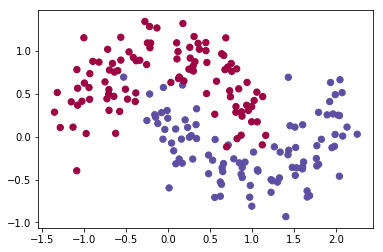

Loss after iteration 0: 0.495881
Loss after iteration 1: 0.421724
Loss after iteration 2: 0.371935
Loss after iteration 3: 0.352960
Loss after iteration 4: 0.341178
Loss after iteration 5: 0.332710
Loss after iteration 6: 0.327040
Loss after iteration 7: 0.323692
Loss after iteration 8: 0.323245
Loss after iteration 9: 0.321409
Loss after iteration 10: 0.321896
Loss after iteration 11: 0.314232
Loss after iteration 12: 0.310482
Loss after iteration 13: 0.301589
Loss after iteration 14: 0.297130
Loss after iteration 15: 0.290930
Loss after iteration 16: 0.287127
Loss after iteration 17: 0.282527
Loss after iteration 18: 0.279195
Loss after iteration 19: 0.275521
Loss after iteration 20: 0.272574
Loss after iteration 21: 0.269513
Loss after iteration 22: 0.266888
Loss after iteration 23: 0.264253
Loss after iteration 24: 0.261890
Loss after iteration 25: 0.259561
Loss after iteration 26: 0.257412
Loss after iteration 27: 0.255313
Loss after iteration 28: 0.253339
Loss after iteration 29:

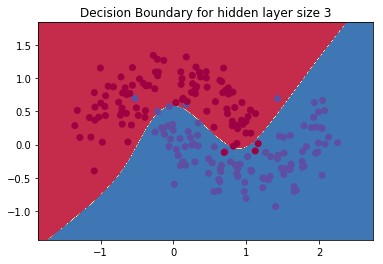

In [134]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model

# Generate a dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(200, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)
plt.show()

layers_dim = [2, 10, 2]

model = Model(layers_dim)
model.train(X, y, num_passes=70, epsilon=0.01, reg_lambda=0.01, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: model.predict(x), X, y)
plt.title("Decision Boundary for hidden layer size 3")
plt.show()